In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def run_sim():
    #1) Initialize parameters.
    tmax = 1000
    dt = 0.01

    #1.1) Neuron/Network pairs.
    c_m = 50 # nF
    v_th = -55 # mV
    v_r = -75 # mV
    g_l = 15 # nS
    e_l = v_r # mV
    v_spike = 20 # mV

    # Bursting parameters
    tau_a = 5 # s
    k_in = 50 # Pa/s
    k_a = 5150 # Pa
    k_e = 600 # Pa

    # PIEZO channel parameters
    g_s = 25 # nS
    e_srev = 10 # mV
    s = .00277 # 1/Pa
    k_b = 106
    m = 25
    q = 1

    #2) Reserve memory
    T = int(np.ceil(tmax / dt))
    v = np.zeros(T)
    sigma_m = np.zeros(T)
    sigma_a = np.zeros(T)
    sigma_w = np.zeros(T)
    i_s = np.zeros(T)

    #2.1) Initialize
    spikes = []
    v[0] = -75 #Resting potential
    sigma_a[0] = 0
    sigma_w[0] = 25000
    sigma_m[0] = sigma_a[0] + sigma_w[0]
    
    #3) For-loop over time.
    for t in np.arange(T-1):
        if v[t] < v_th:
            #3.1) Update DOE.
            i_s[t+1] = g_s / (1 + k_b * np.exp(- s * (sigma_m[t] / m) ** q)) * (v[t] - e_srev)
            i_l = g_l * (v[t] - e_l)
            # update membrane potential
            dv = 1 / c_m * (- i_l - i_s[t])
            v[t+1] = v[t] + dv*dt
            # update active stress
            dsigma_a = - sigma_a[t] / tau_a
            sigma_a[t+1] = sigma_a[t] + dsigma_a * dt
            # update vacuole volume
            dsigma_w = k_in
            sigma_w[t+1] = sigma_w[t] + dsigma_w * dt
        else:
            #3.2) Spike!
            v[t] = 20
            v[t+1] = v_r
            sigma_a[t+1] = sigma_a[t] + k_a
            sigma_w[t+1] = sigma_w[t] - k_e
            i_s[t+1] = i_s[t]
            spikes.append(t*dt)
        
        # update muscle stress
        sigma_m[t+1] = sigma_w[t+1] + sigma_a[t+1]
     
    return v, sigma_a, sigma_w

In [3]:
v, sigma_a, sigma_w = run_sim()

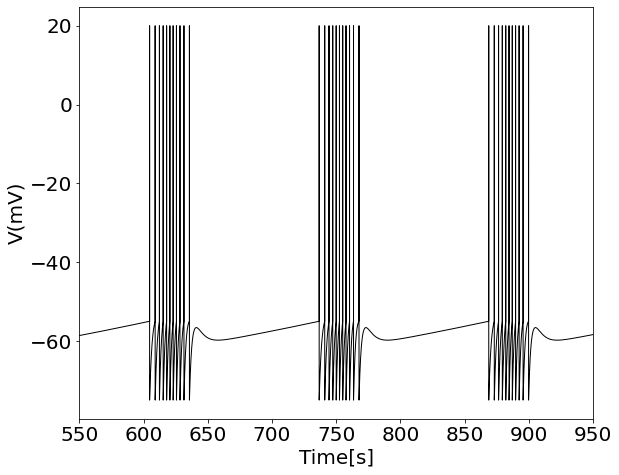

In [10]:
#4) Plot voltage trace
tmax = 1000
dt = .01
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(9,7))
tvec = np.arange(dt, tmax, dt)
ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(212)
ax1.plot(tvec, v[1:], 'k', linewidth=1)
# ax2.plot(tvec, sigma_w[1:]/1000, 'b', label=r'$\sigma_w$')
# ax2.plot(tvec, sigma_a[1:]/1000, 'g', label=r'$\sigma_a$')
ax1.set_xlabel('Time[s]')
# ax2.set_xlabel('Time[s]')
ax1.set_ylabel('V(mV)')
# ax2.set_ylabel('muscle stress (kPa)')
# ax2.legend()
start, end = 550, 950
ax1.set_xlim(start, end)
# ax2.set_xlim(start, end)
plt.tight_layout()
plt.savefig('./output/trace_v.png', dpi=300, bbox_inches='tight')
plt.show()

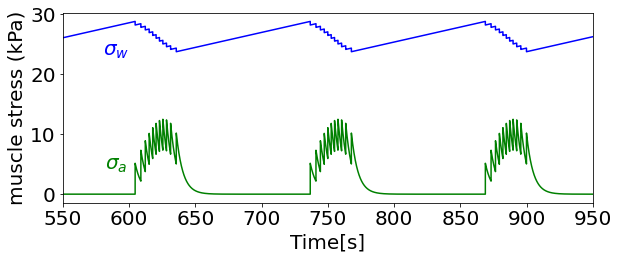

In [31]:
#4) Plot voltage trace
tmax = 1000
dt = .01
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(9,4))
tvec = np.arange(dt, tmax, dt)
ax2 = fig.add_subplot(111)
ax2.plot(tvec, sigma_w[1:]/1000, 'b', label=r'$\sigma_w$')
ax2.plot(tvec, sigma_a[1:]/1000, 'g', label=r'$\sigma_a$')
ax2.set_xlabel('Time[s]')
ax2.set_ylabel('muscle stress (kPa)')
# ax2.legend()
ax2.text(.1, .8, r'$\sigma_w$', color='b', horizontalalignment='center',
     verticalalignment='center', transform=ax2.transAxes)
ax2.text(.1, .2, r'$\sigma_a$', color='g', horizontalalignment='center',
     verticalalignment='center', transform=ax2.transAxes)
start, end = 550, 950
ax2.set_xlim(start, end)
plt.tight_layout()
plt.savefig('./output/trace_stress.png', dpi=300, bbox_inches='tight')
plt.show()

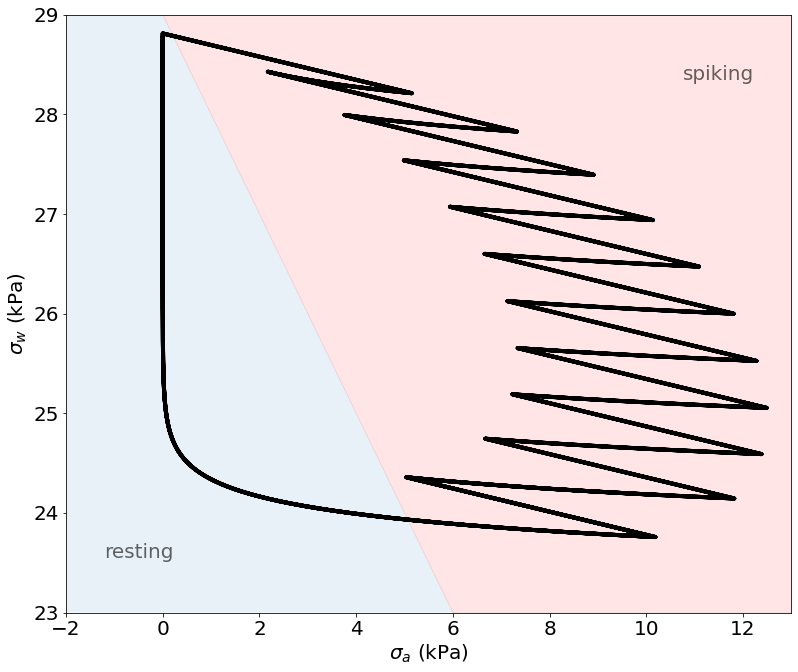

In [105]:
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(13,11))
ax = fig.add_subplot(111)
sigma_a_ = sigma_a[int(500/dt):]/1000
sigma_w_ = sigma_w[int(500/dt):]/1000
plt.plot(sigma_a_, sigma_w_, linewidth=4, color='k')
x = np.array(range(-2, 14))
y = 29 - x
plt.fill_between(x, 23, y, alpha=.1)
plt.fill_between(x, y, 29, alpha=.1, color='r')
plt.xlabel(r'$\sigma_a$ (kPa)')
plt.ylabel(r'$\sigma_w$ (kPa)')
plt.xlim(-2, 13)
plt.ylim(23, 29)
plt.text(.1, .1, 'resting', color='k', alpha=.6, horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
plt.text(.9, .9, 'spiking', color='k', alpha=.6, horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
# plt.tight_layout()
plt.savefig('./output/trajectory.png', dpi=300, bbox_inches='tight')
plt.show()